In [154]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.genes import Gene, Genome

model_organisms = dict()
model_organisms['Pseudomonas aeruginosa'] = 'paer'
model_organisms['Escherichia coli'] = 'ecol'
model_organisms['Mycobacterium tuberculosis'] = 'mtub' 
model_organisms['Bacillus subtilis'] = 'bsub'
model_organisms['Aliivibrio fischeri'] = 'afis'

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
def export_results(path='../data/model_organisms/results.csv', filter_binary_prediction:int=None, filter_ternary_prediction:int=None, filter_blast_possible_match:bool=False):
    '''Combine the results across model organisms, saving the entries which are (1) predicted to be selenoproteins 
    by one of the model types, and which have possible BLAST hits in the reference genome.'''
    results_df = []
    for species, code_name in model_organisms.items():
        species_results_df = pd.read_csv(f'../data/model_organisms/{code_name}_results.csv', index_col=0, dtype={'partial':str})
        results_df.append(species_results_df)
    results_df = pd.concat(results_df)
    
    results_df['start_aligned'] = (results_df.query_alignment_start == 1) & (results_df.query_alignment_start == 1)

    columns = ['species','ternary_model_plm_prediction', 'binary_model_plm_prediction', 'subject_id', 'subject_gene', 'subject_product'] 
    columns += ['seq', 'extended_seq', 'extension_size', 'start_aligned', 'stop_codon', 'sequence_identity']
    columns += [ 'query_sequence_length', 'subject_sequence_length']	
    columns += ['blast_exact_match', 'blast_possible_match']
    results_df = results_df[columns]

    if (filter_binary_prediction is not None):
        results_df = results_df[results_df.binary_model_plm_prediction == filter_binary_prediction]
    if (filter_ternary_prediction is not None):
        results_df = results_df[results_df.ternary_model_plm_prediction == filter_ternary_prediction]

    if filter_blast_possible_match:
        results_df = results_df[results_df.blast_possible_match]

    results_df.to_csv(path)

export_results('../data/model_organisms/results.csv')

In [156]:

def plot_results(results_df:pd.DataFrame, ax:plt.Axes=None, x_lims=None):
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
    cmap = matplotlib.cm.ScalarMappable(cmap=matplotlib.colormaps['coolwarm'], norm=norm)

    def log_scale(vals:pd.DataFrame, epsilon:float=1):
        signs = [-1 if (val < 0) else epsilon for val in vals]
        vals = [abs(val) if (abs(val) > 0) else epsilon for val in vals]
        vals = np.log10(np.abs(vals))
        vals = [sign * val for sign, val in zip(signs, vals)]
        return vals 

    colors = [cmap.to_rgba(val) for val in results_df.sequence_identity]

    y = log_scale(results_df.query_sequence_length - results_df.subject_sequence_length)
    x = results_df.query_sequence_length
    ax.scatter(x, y, color=colors, s=20, edgecolors='black', linewidths=0.5)

    ax.set_xlabel('sequence length')
    ax.set_ylabel('sequence length diff.')
    ax.set_yticks(np.arange(-4, 2), labels=['$10^{' + str(n) + '}$' for n in np.arange(-4, 2)], fontsize='x-small')

    if (x_lims is not None):
        ax.set_xlim(*x_lims)

    cbar = fig.colorbar(cmap, ax=ax)
    cbar.ax.set_title('seq. id.', fontsize='x-small')
    cbar.ax.set_yticks(np.arange(0, 110, 10), labels=np.arange(0, 110, 10), fontsize='x-small')


def plot_results(results_df:pd.DataFrame, ax:plt.Axes, model_type:str=None):
    masks = dict()
    masks[0] = results_df.blast_exact_match 
    masks[1] = (~results_df.blast_exact_match) & results_df.blast_possible_match
    masks[2] = ~results_df.blast_possible_match

    n = 3 if (model_type == 'ternary') else 2

    counts = np.zeros((n, 3))
    row_labels = ['valid', 'error', 'artifact']
    col_labels = [0, 1]

    for i in range(counts.shape[0]):
        pred_mask = (results_df[f'{model_type}_model_plm_prediction'] == i)
        for j in range(counts.shape[1]):
            counts[i, j] = np.sum(pred_mask & masks[j])
            ax.text(j, i, np.sum(pred_mask & masks[j]), ha='center', va='center', color='white') #, weight='bold')

    ax.imshow(np.log10(counts), cmap='coolwarm')
    ax.set_xticks(np.arange(len(row_labels)), labels=row_labels)
    ax.set_yticks(np.arange(n), labels=[f'label {i}' for i in range(n)])

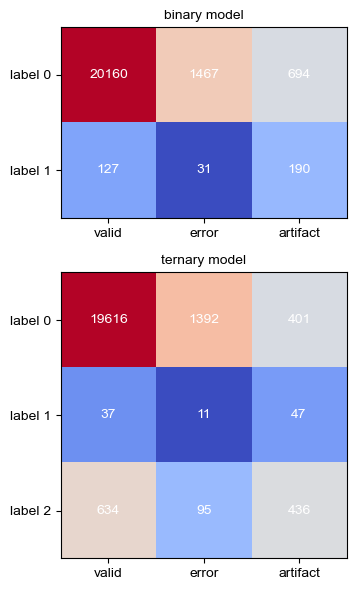

In [157]:

# fig, axes = plt.subplots(figsize=(8, 3), ncols=2)

# for ax, path in zip(axes, ['../data/model_organisms/binary_results.csv', '../data/model_organisms/ternary_results.csv']):
#     plot_results(pd.read_csv(path, index_col=0), ax=ax, x_lims=(0, 300))

# axes[0].set_title('binary model predicted label 1', fontsize='medium')
# axes[1].set_title('ternary model predicted label 1', fontsize='medium')


fig, axes = plt.subplots(figsize=(4, 6), nrows=2, height_ratios=[2/5, 3/5])

for ax, model_type in zip(axes, ['binary', 'ternary']):
    plot_results(pd.read_csv('../data/model_organisms/results.csv', index_col=0), ax=ax, model_type=model_type)

axes[0].set_title('binary model', fontsize='medium')
axes[1].set_title('ternary model', fontsize='medium')



plt.tight_layout()
plt.show()


In [158]:
genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(model_organisms.keys())]
genome_metadata_df['code_name'] = genome_metadata_df.species.replace(model_organisms)

In [159]:
for species, code_name in model_organisms.items():
    metadata_df = FASTAFile(f'../data/model_organisms/gtdb_{code_name}_protein.faa').to_df(parser=fasta_file_parser_gtdb)
    metadata_df = pd.concat([metadata_df, genome_metadata_df[genome_metadata_df.code_name == code_name]], axis=1)
    metadata_df = metadata_df.bfill()
    metadata_df.index.name = 'id'
    metadata_df.seq = metadata_df.seq.str.replace('*', '')
    metadata_df.to_csv(f'../data/model_organisms/gtdb_{code_name}_metadata.csv')

In [59]:
species, code_name = 'Escherichia coli', 'ecol'
# species, code_name = 'Mycobacterium tuberculosis', 'mtub'
species, code_name = 'Pseudomonas aeruginosa', 'paer'
# species, code_name = 'Aliivibrio fischeri', 'afis'
# species, code_name = 'Bacillus subtilis', 'bsub'

blast_df = BLASTFile(f'../data/model_organisms/gtdb_{code_name}_protein.blast.tsv', max_e_value=10).to_df()
    
gbff_cols = ['start', 'stop', 'protein_id', 'strand', 'note', 'product', 'gene'] # , 'go_function', 'go_process', 'go_component', 'ec_number']
gbff_df = GBFFFile(f'../data/model_organisms/ncbi_{code_name}_genomic.gbff').to_df()[gbff_cols].rename(columns={col:f'subject_{col}' for col in gbff_cols})

predictions_df = pd.read_csv(f'../data/results/gtdb_{code_name}.predict.csv', index_col=0)

results_df = blast_df.merge(gbff_df, left_on='subject_id', right_on='subject_protein_id', how='left')
results_df.index = blast_df.index
results_df = predictions_df.merge(results_df, left_index=True, right_index=True, how='outer')

BLASTFile.load: Loaded 5787 out of 5787 entries which met the E-value threshold <= 10.000.
GBFFFile.__init__: Found 5785 coding sequences in the GBFF file.


GBFFFile.__init__: Parsing GBFF file entries.: 100%|██████████| 5785/5785 [00:01<00:00, 5365.88it/s] 

GBFFFile.__init__: Removing 119 entries with no protein ID.
GBFFFile.remove_duplicates: Removing 9 duplicate entries from the GBFF file.


In [60]:
# Extend the predicted selenoproteins in the results DataFrame. 
genome = Genome(f'../data/model_organisms/ncbi_{code_name}_genomic.fna')
extended_df = {'id':[], 'stop_codon':[], 'extension_size':[], 'extended_seq':[]}
for row in results_df.itertuples():
    gene = Gene(row.Index, genome, start=int(row.start - 1), stop=int(row.stop), strand=row.strand) 
    extended_df['stop_codon'] += [gene.stop_codon]
    extended_df['id'] += [row.Index]

    if (row.binary_model_plm_prediction == 1) or (row.ternary_model_plm_prediction == 1):
        gene = gene.extend(error='ignore')
        extended_df['extension_size'] += [gene.extension_size]
        extended_df['extended_seq'] += [gene.translate()]
    else:
        extended_df['extension_size'] += [0]
        extended_df['extended_seq'] += ['']    
extended_df = pd.DataFrame(extended_df).set_index('id')
results_df = results_df.merge(extended_df, left_index=True, right_index=True, how='left')
        

In [61]:
# NOTE: Should I incorporate E-value thresholds? If so, what should I use?
# NOTE: Why are there some sequences which are nearly exact matches, but are on opposite strands?

def blast_possible_match(row) -> bool:
    if pd.isnull(row.subject_id):
        return False
    if row.sequence_identity < 95:
        return False
    return True 


def blast_exact_match(row) -> bool:
    if pd.isnull(row.subject_id):
        return False
    if row.sequence_identity < 95:
        return False  
    if not math.isclose(row.subject_sequence_length, row.query_sequence_length, abs_tol=5):
        return False
    return True
    
results_df['blast_possible_match'] = results_df.apply(blast_possible_match, axis=1)
results_df['blast_exact_match'] = results_df.apply(blast_exact_match, axis=1)
results_df.to_csv(f'../data/model_organisms/{code_name}_results.csv')

In [62]:
ternary_results = {i:results_df[results_df.ternary_model_plm_prediction == i] for i in range(3)}
binary_results = {i:results_df[results_df.binary_model_plm_prediction == i] for i in range(2)}

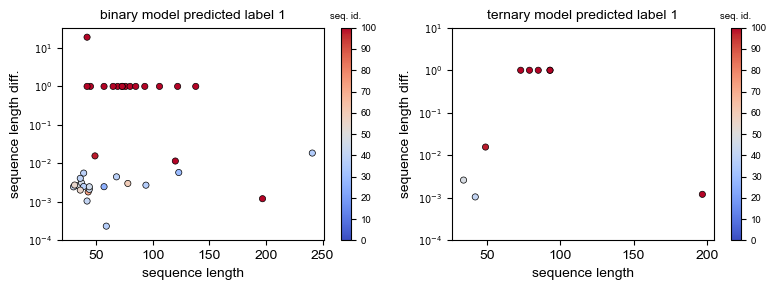

In [122]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2)

for ax, results in zip(axes, [binary_results, ternary_results]):
    plot_results(results[1], ax=ax)

axes[0].set_title('binary model predicted label 1', fontsize='medium')
axes[1].set_title('ternary model predicted label 1', fontsize='medium')


plt.tight_layout()
plt.show()

# A large fraction of the sequences which are predicted to be truncated selenoproteins seem to be these spurious sequences, 
# likely Prodigal artifacts (if we assume the curated reference genomes are "ground truth"). I suspect the model is sensitive 
# to sequences that just don't... look right. Adding the third class to the training set seems to have alleviated this 
# problem by helping the model distinguish between artifacts and true positives. 

# Because Prodigal *does* work, it makes sense that the artifacts it generates do bear some resemblance to real proteins, 
# which explains why they still have BLAST hits... I suspect the sequence identities would be much higher if I 
# BLASTED them against all of the selenoproteins in the training set, for example. That's why it makes sense to use truncated 
# full-length proteins as the third class. We want to preserve the "reasonableness" of the artifacts/fragments.

# I do wonder if adding a fourth class of short, full-length proteins would help cut down on the remaining false-
# positives. 

# I am also curious about why it singled out some fragments and not others. It does seem to predict
# a majority of the fragments to be non-selenoproteins. I wonder if it has to do with the truncation ratio... 
# This could be a good rationale for the method I used for generating truncated proteins.

# The third class also seems to have made the model somewhat less sensitive to length, which is good, as many of the
# clear false positives are just very small proteins. 


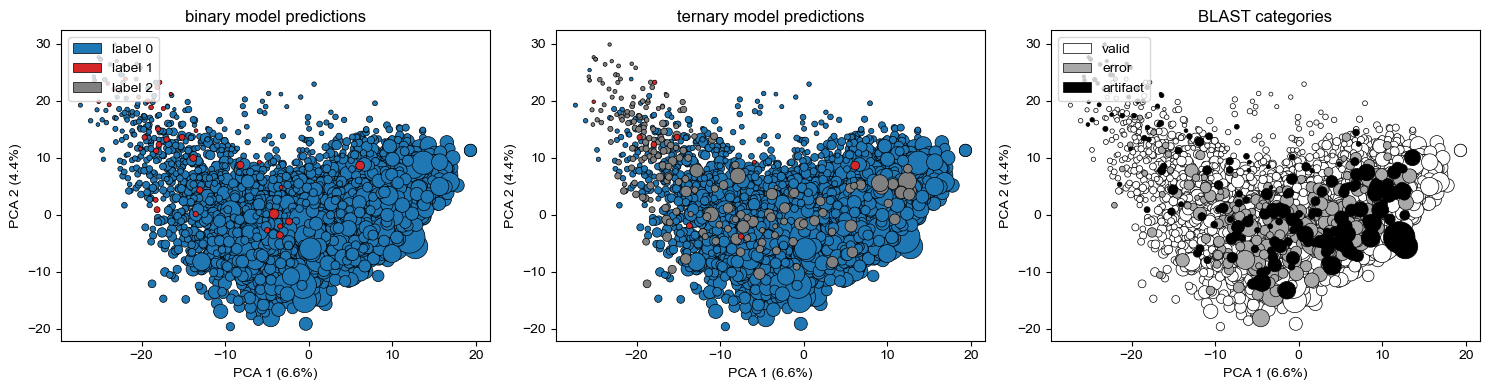

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(figsize=(15, 4), ncols=3)


embeddings_df = pd.read_hdf(f'../data/model_organisms/gtdb_{code_name}.h5', key='plm')
pred_colors = {1:'tab:red', 0:'tab:blue', 2:'gray'}
cat_colors = {0:'white', 1:'darkgray', 2:'black'}

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings_df.values)
pca = PCA(n_components=2)

components = pca.fit_transform(embeddings)
ev_1, ev_2 = pca.explained_variance_ratio_

for pred in [0, 1]:
    mask = (results_df.binary_model_plm_prediction == pred)
    sizes = results_df[mask].query_sequence_length / 5
    axes[0].scatter(components[mask, 0].ravel(), components[mask, 1].ravel(), color=pred_colors[pred], s=sizes, edgecolors='black', linewidths=0.5)
    axes[0].set_xlabel(f'PCA 1 ({ev_1 * 100:.1f}%)')
    axes[0].set_ylabel(f'PCA 2 ({ev_2 * 100:.1f}%)')

for pred in [0, 2, 1]:
    mask = (results_df.ternary_model_plm_prediction == pred)
    sizes = results_df[mask].query_sequence_length / 5
    axes[1].scatter(components[mask, 0].ravel(), components[mask, 1].ravel(), color=pred_colors[pred], s=sizes, edgecolors='black', linewidths=0.5)
    axes[1].set_xlabel(f'PCA 1 ({ev_1 * 100:.1f}%)')
    axes[1].set_ylabel(f'PCA 2 ({ev_2 * 100:.1f}%)')

masks = dict()
masks[0] = results_df.blast_exact_match 
masks[1] = (~results_df.blast_exact_match) & results_df.blast_possible_match
masks[2] = ~results_df.blast_possible_match

for cat in [0, 1, 2]:
    mask = masks[cat]
    sizes = results_df[masks[cat]].query_sequence_length / 5
    axes[2].scatter(components[mask, 0].ravel(), components[mask, 1].ravel(), color=cat_colors[cat], s=sizes, edgecolors='black', linewidths=0.5)
    axes[2].set_xlabel(f'PCA 1 ({ev_1 * 100:.1f}%)')
    axes[2].set_ylabel(f'PCA 2 ({ev_2 * 100:.1f}%)')

axes[0].legend(handles=[Patch(facecolor=pred_colors[pred], edgecolor='black', linewidth=0.5) for pred in [0, 1, 2]], labels=['label 0', 'label 1', 'label 2'], loc='upper left')
axes[2].legend(handles=[Patch(facecolor=cat_colors[cat], edgecolor='black', linewidth=0.5) for cat in [0, 1, 2]], labels=['valid', 'error', 'artifact'], loc='upper left')

axes[0].set_title('binary model predictions')
axes[1].set_title('ternary model predictions')
axes[2].set_title('BLAST categories')

plt.tight_layout()
plt.show()

# It's possible that errors are due to differences in the translation table. 
# No, it seems as though the tables are the same. Not sure quite went wrong, but there are some C-terminal truncation events
# which are not due to selenoproteins. Also errors where the start codon has been mis-predicted, which makes more sense. 